# Sentiment Analysis of Real-time Flipkart Product Reviews

### Import the libraries

In [1]:
import nltk
import re
import emoji
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import autocorrect 
from textblob import TextBlob 
from warnings import filterwarnings
filterwarnings("ignore")
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer,LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score,ConfusionMatrixDisplay,recall_score,precision_score

In [2]:
df = pd.read_csv("data.csv")

In [3]:
df

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1
...,...,...,...,...,...,...,...,...
8513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
8514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
8515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
8516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [4]:
df.shape

(8518, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB


In [6]:
df.isna().sum()

Reviewer Name       10
Review Title        10
Place of Review     50
Up Votes            10
Down Votes          10
Month              465
Review text          8
Ratings              0
dtype: int64

In [7]:
df['Review text']

0       Nice product, good quality, but price is now r...
1       They didn't supplied Yonex Mavis 350. Outside ...
2       Worst product. Damaged shuttlecocks packed in ...
3       Quite O. K. , but nowadays  the quality of the...
4       Over pricedJust â?¹620 ..from retailer.I didn'...
                              ...                        
8513                                                  NaN
8514                                                  NaN
8515                                                  NaN
8516                                                  NaN
8517                                                  NaN
Name: Review text, Length: 8518, dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB


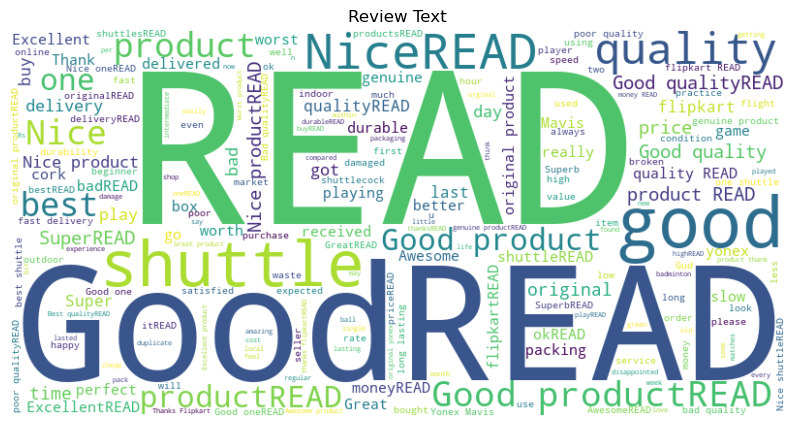

In [9]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['Review text'].dropna()))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Review Text')
plt.show()

### Text Preprocessing

In [10]:
# Impute missing values for 'Month' and 'Place of Review' with the mode
fill_values = {'Month': df['Month'].mode()[0], 'Place of Review': df['Place of Review'].mode()[0]}
df.fillna(value=fill_values, inplace=True)


In [11]:
# Impute missing values for 'Down Votes' and 'Up Votes' with the mean
mean_values = {'Down Votes': df['Down Votes'].mean(), 'Up Votes': df['Up Votes'].mean()}
df.fillna(value=mean_values, inplace=True)

In [12]:
# Drop rows with NaN values in the specified columns
df.dropna(subset=['Review text', 'Reviewer Name', 'Review Title'], inplace=True)

In [13]:
df.isna().sum()

Reviewer Name      0
Review Title       0
Place of Review    0
Up Votes           0
Down Votes         0
Month              0
Review text        0
Ratings            0
dtype: int64

In [14]:
# Checking duplicates 
df.duplicated().sum()

0

In [15]:
df['Review text']

0       Nice product, good quality, but price is now r...
1       They didn't supplied Yonex Mavis 350. Outside ...
2       Worst product. Damaged shuttlecocks packed in ...
3       Quite O. K. , but nowadays  the quality of the...
4       Over pricedJust â?¹620 ..from retailer.I didn'...
                              ...                        
8503    Wrost and duplicate productDon't buy this sell...
8504          Received product intact and sealedREAD MORE
8505    Delivered before time but price is high from m...
8506    up to the mark but same is available in market...
8507                         Nice delivery speedREAD MORE
Name: Review text, Length: 8508, dtype: object

In [16]:
def eda(df, column):
    count = 0
    count = df[column].apply(lambda x: count + emoji.emoji_count(x)).sum()  # emoji count in th data
    lower = df[column].str.islower().sum()
    url = df[column].apply(lambda x: True if re.search(r'www.\S+ | https?://\S+', x) else False).sum()
    tags =  df[column].apply(lambda x: True if re.search(r'<[^>]+>', x) else False).sum()
    punc = df[column].apply(lambda x: True if re.search(r'[^A-z ]+', x) else False).sum()
    nums = df[column].apply(lambda x: True if re.search(r'[0-9]', x) else False).sum()
    return  pd.Series({'Emoji':count, "lower case":lower, "urls":url, "HTML tags":tags, "punctuation":punc, "Numbers":nums})


In [17]:
eda(df,'Review text')

Emoji           684
lower case        0
urls              0
HTML tags         0
punctuation    2935
Numbers         673
dtype: int64

### Removing Emojis 

In [18]:
# Apply the lambda function to remove emojis from the 'Review text' column
df['Review text'] = df['Review text'].apply(lambda text: emoji.demojize(text))


### Removing punctuation

In [19]:
# Applying lambda function to remove punctuation from the 'Review text' column
df['Review text'] = df['Review text'].apply(lambda x: re.sub(r'[\.,''\']+',' ', x))

### Removing numbers

In [20]:
# Applying lambda function to remove numbers from the 'Review text' column
df['Review text'] = df['Review text'].apply(lambda x: re.sub(r'\d+', '', x))

### Converting to lowercase

In [21]:
# converting into lower case
df['Review text'] = df['Review text'].apply(lambda text: text.lower())

### Tokenization

In [22]:
# Tokenize the text in the 'Review text' column
df['Review text'] = df['Review text'].apply(lambda x:" ".join(word_tokenize(x)))


### Removing special characters

In [23]:
# Remove specific characters from the 'Review text' column using pandas' replace function
df['Review text'] = df['Review text'].str.replace('â', '').str.replace('¹', '').str.replace('?', '')


In [24]:
df['Review text']

0       nice product good quality but price is now ris...
1       they didn t supplied yonex mavis outside cover...
2       worst product damaged shuttlecocks packed in n...
3       quite o k but nowadays the quality of the cork...
4       over pricedjust    from retailer i didn t unde...
                              ...                        
8503    wrost and duplicate productdon t buy this sell...
8504          received product intact and sealedread more
8505    delivered before time but price is high from m...
8506    up to the mark but same is available in market...
8507                         nice delivery speedread more
Name: Review text, Length: 8508, dtype: object

### Removing the Stopwords

In [25]:
stopwords = stopwords.words('english')

def remove_stopwords(text):
    tokens = word_tokenize(text)

    filtered_tokens = [word for word in tokens if word.lower() not in stopwords]
    
    filtered_text = ' '.join(filtered_tokens)
    
    return filtered_text
df['Review text'] = df['Review text'].apply(remove_stopwords)

In [26]:
df['Review text']

0       nice product good quality price rising bad sig...
1       supplied yonex mavis outside cover yonex ad in...
2       worst product damaged shuttlecocks packed new ...
3       quite k nowadays quality corks like years back...
4       pricedjust retailer understand wat advantage b...
                              ...                        
8503    wrost duplicate productdon buy seller productf...
8504                   received product intact sealedread
8505                 delivered time price high marketread
8506                mark available market less price read
8507                              nice delivery speedread
Name: Review text, Length: 8508, dtype: object

### Text Normalization

In [27]:
stemmer = PorterStemmer()

In [28]:
def stemmer_function(text):
    stemmed_words = [stemmer.stem(word) for word in text.split()]
    return " ".join(stemmed_words)

df['Review text'] = df['Review text'].apply(stemmer_function)


In [29]:
df['Review text']

0       nice product good qualiti price rise bad sign ...
1       suppli yonex mavi outsid cover yonex ad insid ...
2       worst product damag shuttlecock pack new box o...
3       quit k nowaday qualiti cork like year back use...
4       pricedjust retail understand wat advantag buy ...
                              ...                        
8503    wrost duplic productdon buy seller productflip...
8504                     receiv product intact sealedread
8505                     deliv time price high marketread
8506                    mark avail market less price read
8507                              nice deliveri speedread
Name: Review text, Length: 8508, dtype: object

### Numerical Feature Extraction

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

In [31]:
vector= vectorizer.fit_transform(df['Review text']).toarray()

In [32]:
vector

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [33]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mohds\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [34]:
SA = SentimentIntensityAnalyzer()

In [35]:
def polarity(x):
    return SA.polarity_scores(x)['compound']

In [36]:
df['Emotion'] = df['Review text'].apply(polarity)

In [37]:
def sentiment(x):
    if x > 0.3:
        return 'Positive'
    
    else:
        return 'Negative'

In [38]:
df['Emotion'] = df['Emotion'].apply(sentiment)

In [39]:
df['Emotion']

0       Positive
1       Negative
2       Negative
3       Positive
4       Negative
          ...   
8503    Negative
8504    Negative
8505    Negative
8506    Negative
8507    Positive
Name: Emotion, Length: 8508, dtype: object

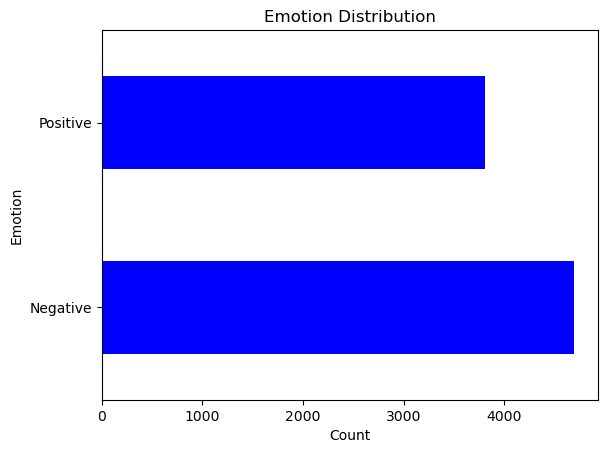

In [40]:
df['Emotion'].value_counts().plot(kind='barh', color='blue')  # Horizontal bar plot
plt.xlabel('Count')
plt.ylabel('Emotion')
plt.title('Emotion Distribution')
plt.show()

In [41]:
df1 = pd.concat([df['Review text'],df['Emotion']],axis=1)

In [42]:
df1

,Review text,Emotion
0,nice product good qualiti price rise bad sign ...,Positive
1,suppli yonex mavi outsid cover yonex ad insid ...,Negative
2,worst product damag shuttlecock pack new box o...,Negative
3,quit k nowaday qualiti cork like year back use...,Positive
4,pricedjust retail understand wat advantag buy ...,Negative
...,...,...
8503,wrost duplic productdon buy seller productflip...,Negative
8504,receiv product intact sealedread,Negative
8505,deliv time price high marketread,Negative
8506,mark avail market less price read,Negative


In [43]:
df['Emotion'].value_counts()

Emotion
Negative    4696
Positive    3812
Name: count, dtype: int64

### Identify Input and Output

In [44]:
X=df1['Review text']
y=df1['Emotion']

In [45]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [46]:
from sklearn.linear_model import LogisticRegression

In [47]:
lr_pipe = Pipeline([
    ('TfIdf_Vectorization', TfidfVectorizer(stop_words='english')),
    ('Estimator', LogisticRegression())])


lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('TfIdf_Vectorization', TfidfVectorizer(stop_words='english')),
                ('Estimator', LogisticRegression())])

In [48]:
lr_predictions = lr_pipe.predict(X_test)

In [49]:

lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_f1_score = f1_score(y_test, lr_predictions, average='weighted')

print("Logistic Regression Accuracy:", lr_accuracy)
print("Logistic Regression F1 Score:", lr_f1_score)

Logistic Regression Accuracy: 0.982373678025852
Logistic Regression F1 Score: 0.9823629385214274


In [50]:
lr_conf_matrix = confusion_matrix(y_test, lr_predictions)

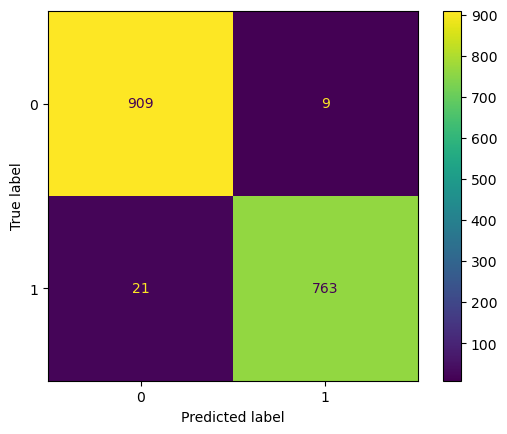

In [51]:
ConfusionMatrixDisplay(confusion_matrix=lr_conf_matrix).plot()


In [52]:
print(classification_report(y_test, lr_predictions))

              precision    recall  f1-score   support

    Negative       0.98      0.99      0.98       918
    Positive       0.99      0.97      0.98       784

    accuracy                           0.98      1702
   macro avg       0.98      0.98      0.98      1702
weighted avg       0.98      0.98      0.98      1702



In [53]:
pipe = Pipeline([
    ('TfIdf_Vectorization', TfidfVectorizer(stop_words='english')),
    ('Estimator', MultinomialNB(alpha=3))])

In [54]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('TfIdf_Vectorization', TfidfVectorizer(stop_words='english')),
                ('Estimator', MultinomialNB(alpha=3))])

In [55]:
y_pred = pipe.predict(X_test)

In [56]:
accuracy_score(y_test,y_pred)

0.8948296122209166

In [57]:
f1_score(y_test, y_pred, average='weighted')

0.8949223175061537

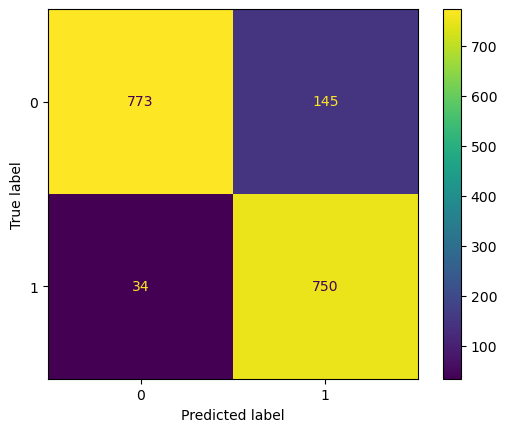

In [58]:
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot()

In [59]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

    Negative       0.96      0.84      0.90       918
    Positive       0.84      0.96      0.89       784

    accuracy                           0.89      1702
   macro avg       0.90      0.90      0.89      1702
weighted avg       0.90      0.89      0.89      1702



In [60]:
from sklearn.neighbors import KNeighborsClassifier

knn_pipe = Pipeline([
    ('TfIdf_Vectorization', TfidfVectorizer(stop_words='english')),
    ('Estimator', KNeighborsClassifier())
])


knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('TfIdf_Vectorization', TfidfVectorizer(stop_words='english')),
                ('Estimator', KNeighborsClassifier())])

In [61]:
knn_predictions = knn_pipe.predict(X_test)

In [62]:
knn_accuracy = accuracy_score(y_test, knn_predictions)
knn_f1_score = f1_score(y_test, knn_predictions, average='weighted')

print("KNN Accuracy:", knn_accuracy)
print("KNN F1 Score:", knn_f1_score)

KNN Accuracy: 0.854289071680376
KNN F1 Score: 0.8544883951991499


In [63]:
knn_conf_matrix = confusion_matrix(y_test, knn_predictions)

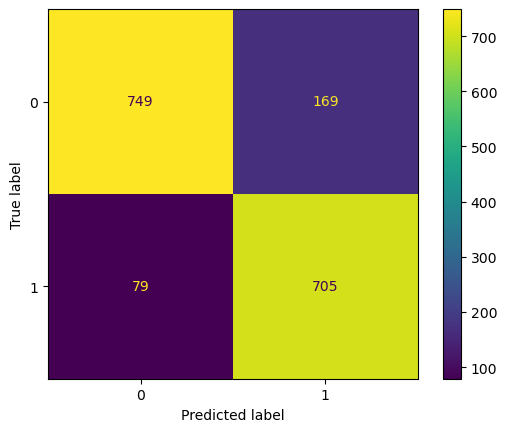

In [64]:
ConfusionMatrixDisplay(confusion_matrix=knn_conf_matrix).plot()


In [65]:
print(classification_report(y_test, knn_predictions))

              precision    recall  f1-score   support

    Negative       0.90      0.82      0.86       918
    Positive       0.81      0.90      0.85       784

    accuracy                           0.85      1702
   macro avg       0.86      0.86      0.85      1702
weighted avg       0.86      0.85      0.85      1702



## Creating pickel file

In [66]:
import pickle

In [67]:
pickle.dump(lr_pipe,open("sentiment.pkl",'wb'))

In [68]:
predict = pickle.load(open("sentiment.pkl",'rb'))